In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold

sys.path.insert(0, '..')

from utils import UnityScaler


In [13]:
reads_threshold = 6000

data_directory = '../data/'
data_filename = 'metaanalysis_data.pickle'
metadata_filename = 'metaanalysis_metadata.pickle' 

data = pickle.load(open(os.path.join(data_directory, data_filename), 'rb'))
metadata = pickle.load(open(os.path.join(data_directory, metadata_filename), 'rb'))

# remove samples with fewer than reads_threshold 
data = data.loc[data.sum(axis = 1) >= reads_threshold]
metadata = metadata.loc[data.index]

# label encoder
label_encoder = LabelEncoder()
metadata['Status'] = label_encoder.fit_transform(metadata['Status'])

# normalize each sample
data = UnityScaler().fit_transform(data)

# fill in metadata
metadata['Variable_Region'] = [v.replace('-','') for v in metadata['Variable_Region']]
metadata['Country'].replace(np.nan, 'USA', inplace = True)
metadata['Sex'].replace(np.nan, 'Unknown', inplace = True)

metadata['Status'] = 1 - metadata['Status']  

In [14]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_curve, roc_auc_score

model = GradientBoostingClassifier()

repeats = 50
colors = ['#CE3534', '#741B47', '#1F78B4']

scores = {}

def get_tpr(x, y , repeats = 5):
    fpr_mean = np.linspace(0, 1, 100)
    tprs, aucs, accuracy, f1 = [], [], [], []
    for train_index, test_index in RepeatedKFold(n_splits = 5, n_repeats = repeats, random_state = 1).split(y):
        try:

            xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
            ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

            model.fit(xtrain, ytrain)

            fpr, tpr, threshold = roc_curve(ytest, model.predict_proba(xtest)[:, 1])
            interp_tpr = np.interp(fpr_mean, fpr, tpr)
            interp_tpr[0] = 0

            tprs.append(interp_tpr)
            aucs.append(roc_auc_score(ytest, model.predict(xtest)))
            accuracy.append(accuracy_score(ytest, model.predict(xtest)))
            f1.append(f1_score(ytest, model.predict(xtest)))
        except:
            continue
    return np.array(tprs), np.array(aucs), np.array(accuracy), np.array(f1)
    
def plot(mean, sem, label, color):
    plt.fill_between(np.linspace(0, 1, 100), mean - sem, mean + sem, alpha = 0.5, color = color)
    plt.plot(np.linspace(0, 1, 100), mean, label = label, color = color)
     
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(bbox_to_anchor = (1, 1))

/home/erxw/anaconda3/envs/precidiag/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


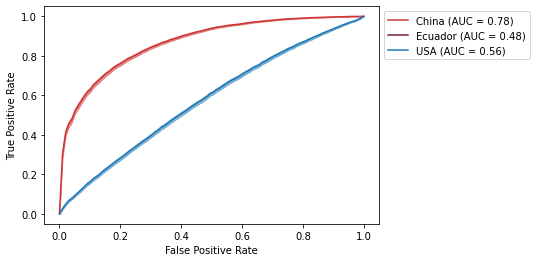

In [15]:
fig, ax = plt.subplots()

for i, (group, df) in enumerate(metadata.groupby('Country')):
    tprs, aucs, accuracy, f1 = get_tpr(data.loc[df.index], df['Status'], repeats)
    scores['Country', group] = (aucs, accuracy, f1)
    plot(np.mean(tprs,axis = 0), np.std(tprs, axis = 0) / np.sqrt(repeats), f'{group} (AUC = {np.mean(aucs):.2f})', colors[i])

plt.savefig('Split_by_Country.pdf', dpi = 1200)

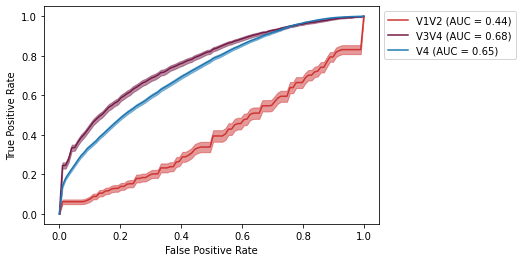

In [16]:
fig, ax = plt.subplots()

for i, (group, df) in enumerate(metadata.groupby('Variable_Region')):
    tprs, aucs, accuracy, f1 = get_tpr(data.loc[df.index], df['Status'], repeats)
    scores['Variable_Region', group] = (aucs, accuracy, f1)
    plot(np.mean(tprs,axis = 0), np.std(tprs, axis = 0) / np.sqrt(repeats), f'{group} (AUC = {np.mean(aucs):.2f})', colors[i])


plt.savefig('Split_by_Variable_Region.pdf', dpi = 1200)

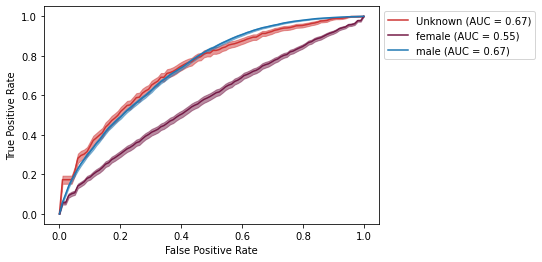

In [17]:
fig, ax = plt.subplots()

for i, (group, df) in enumerate(metadata.groupby('Sex')):
    tprs, aucs, accuracy, f1 = get_tpr(data.loc[df.index], df['Status'], repeats)
    scores['Sex', group] = (aucs, accuracy, f1)
    plot(np.mean(tprs,axis = 0), np.std(tprs, axis = 0) / np.sqrt(repeats), f'{group} (AUC = {np.mean(aucs):.2f})', colors[i])


plt.savefig('Split_by_Sex.pdf', dpi = 1200)

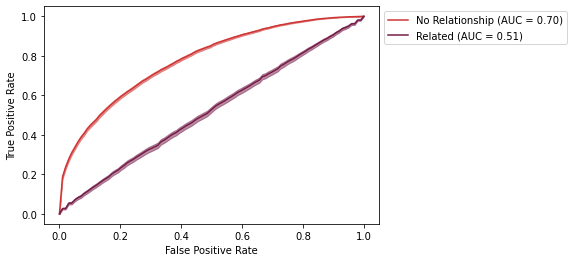

In [18]:
fig, ax = plt.subplots()

for i, (group, df) in enumerate(metadata.groupby('Control_relation')):
    tprs, aucs, accuracy, f1 = get_tpr(data.loc[df.index], df['Status'], repeats)
    scores['Control_relation', group] = (aucs, accuracy, f1)
    plot(np.mean(tprs,axis = 0), np.std(tprs, axis = 0) / np.sqrt(repeats), f'{group} (AUC = {np.mean(aucs):.2f})', colors[i])


plt.savefig('Split_by_relationship.pdf', dpi = 1200)

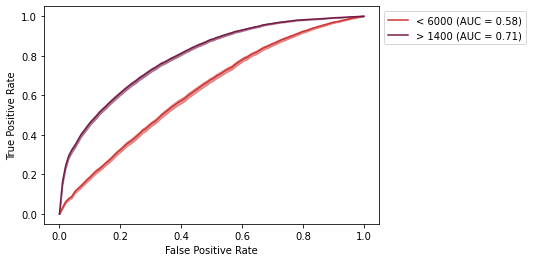

In [19]:
fig, ax = plt.subplots()

for i, (group, df) in enumerate(metadata.groupby('seq_depth_range')):
    tprs, aucs, accuracy, f1 = get_tpr(data.loc[df.index], df['Status'], repeats)
    scores['seq_depth_range', group] = (aucs, accuracy, f1)
    plot(np.mean(tprs,axis = 0), np.std(tprs, axis = 0) / np.sqrt(repeats), f'{group} (AUC = {np.mean(aucs):.2f})', colors[i])


plt.savefig('Split_by_seq_depth_range.pdf', dpi = 1200)

In [20]:
metrics = ['AUC', 'Accuracy', 'F1 Score']
means = pd.concat([pd.Series({(k[0], k[1], metrics[i]) : a.mean() for i, a in enumerate(v)}) for k, v in scores.items()])
sems = pd.concat([pd.Series({(k[0], k[1], metrics[i]) : a.std() /np.sqrt(repeats) for i, a in enumerate(v)}) for k, v in scores.items()])
output = pd.concat([means, sems], axis = 1)
output.columns = ['average', 'sem']
output.to_csv('metadata metrics.csv', sep = '\t')